Forked from Basic Feature Benchmark, courtesy inversion (https://www.kaggle.com/inversion/basic-feature-benchmark)

**What can we learn from Medical warning systems to help improve this Earthquake warning system?**

As a potential lifesaving warning device, LANL Earthquake Prediction has much in common with other lifesaving warning devices, most notably medical devices. There is additional commonality, in that many data scientists and researchers work on several machine learning areas, so I expect participants analyzing geophysical data in this competition may also be interested in biomedical signal analysis. Because of this, I wanted to share the very latest "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML) – Based Software as a Medical Device (SaMD)" published earier this month by the United States Food and Drug Administration (FDA).

The FDA Document helps us categorize the system, describe ongoing changes to the system, and discusses good machine learning practices.

I will break down the components of the proposed regulatory framework, and use this example Kernel to demonstrate how it might impact your future work as a researcher, programmer, and data scientist.

I will first give a **summary of the medical device document**, its pertinent details, and invitation for feedback. I will then **use this Kernel to demonstrate** the similarities between medical warning devices with LANL Earthquake Prediciton, and what learnings from the former might inform our creation of the latter. 

**WHAT IS IN THE *MEDICAL DEVICE* DOCUMENT?**

On April 2, 2019, the US FDA posted the **"Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML) – Based Software as a Medical Device (SaMD)"** document, found here (https://www.regulations.gov/document?D=FDA-2019-N-1185-0001)

**EXECUTIVE SUMMARY**

The framework first categorizes the “risk” of the AI/ML-based SaMD as being levels, I, II, III, or IV, from lowest to highest, based on a combination of how critical the healthcare situation is, and also how significant the SaMD classification will be to the final healthcare decision. The framework goes on from there to categorize the three (3) “types of modifications” which can help developers decide when a formal (510[k]) review is required. The three types are i) Performance, ii) Inputs, and iii) Intended use.

**PERTINENT DETAILS**

The proposal has not yet been made into regulation, and so may change substantially or be withdrawn, but some aspects of the current proposal are pertinent to those working in the field. These details include:

* SaMD’s are subdivided into three broad classes based on how significant the SaMD classification will be to the final healthcare decision. These three are “Inform clinical management,” “Drive clinical management,” and “Treat or diagnose.” These classes drive the clinical risk (from I to IV), further modified by the state of the healthcare situation or condition (Critical, Serious, or Non-serious). 
* Modifications are divided into three broad categories as follows:
* Performance: Modifications related to performance, with no change to the intended use or new input type. This may include re-training with new data sets within the intended use population from the same type of input signal. As a “litmus test” this type of change will NOT change any of the explicit use claims about the product.
* Inputs: Modifications to inputs, with no change in intended use. These changes may also involve changes to the algorithm for use with new types of signals, but do not change the product use claims. As examples, the document cites “modification to support compatibility with CT scanners from additional manufacturers,” or an atrial fibrillation diagnoses system that now will “include oximetry data in addition to heart rate data.”

* Intended Use: These types of modifications include those that result in a change in the significance of information provided by the SaMD and/or result in a change to the healthcare situation or condition explicitly claimed by the manufacturer. Examples include an expanded patient population, such as the inclusion of pediatric population when the original SaMD was initially intended for adults, or an expanded number of diseases or conditions, such as for lesion detection from one type of cancer to another.
* Finally, the proposal also examines the total product lifecycle, with an understanding that AI/ML-based technologies have the potential to transform healthcare by deriving new and important insights from the vast amount of data generated during the delivery of healthcare every day.

**INVITATION FOR FEEDBACK BY THE US FDA**

Although the entire document is open so as to initiate discussion and for the whole world to provide feedback, there are two major areas that seem to stand out as needing expert advice. The first is the “GMLP” or “Good Machine Learning Practices” which, if followed, can insure that the SaMD is accurate, reliable, precise, and achieves the intended purpose. The second is the establishment of the SPS and ACP filings. The “SPS”, or SaMD Pre-Specification describes the anticipated modifications. The “ACP”, or Algorithm Change Protocol, covers the steps used to control risks of violating GMLP.

**HOW CAN WE TAKE LEARNINGS FROM THE ABOVE AN APPLY THEM TO LANL EARTHQUAKE PREDICTION?**

There are three main areas where I thought it might be useful to implement "medical style" methods to this competition - but I definitely welcome your feedback and further brainstorming.

1. Being clear about how we categorize the device and its intended use.
1. Making plans for future modifications.
1. Using good machine learning practices learned from medicine.

First, some Kernel Basics...

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

# For future use - to use CNN to extract features instead pf simple min/max/etc..
from keras.layers import * 
from keras.models import Model, Sequential, load_model
from keras import backend as K 
from keras import optimizers 
from keras.callbacks import * 
from keras.backend import clear_session

Using TensorFlow backend.


**Being clear about how we categorize the device and its intended use.**

From a medical perspective, the FDA thinks of these deivces ase being used for one of three (3) major purposes.

The major purposes are “Inform clinical management,” “Drive clinical management,” and “Treat or diagnose.” 

**How can we relate this to LANL Earthquake prediction?**

1. If this Kernel is to merely "inform" then perhaps data will be recorded, or indicators may be used.
1. If this Kernel must "drive" then perhaps an earthquake alarm will sound, and people who have practiced earthquake drills will take action
1. If this Kernel will "treat" or take action, then perhaps the result will be an automatic shutdown of an assembly line, or other costly event that will be worth the cost if there is indeed an earthquake.

**What does that mean to the software?***

The current contest accounts for major purpose 1 above, with a range of approximately 0 to 16 time to failure. If major purpose 2 or 3 are needed, then perhaps we have to be more certain of not having too many false alarms, and we may want to have a different target "y" that is not a numerical "time till earthquake" but rather a binary choice. Using the data provided in this contest, perhaps we only "pull the alarm" if the earthquake is at some median value.

In [3]:
rows = 150_000
segment = 0
for chunk in tqdm(pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float16}, chunksize=rows * 100)) :
    if (segment == 0) :
        X_train = np.int16(chunk.acoustic_data.values)
        y_raw = np.float16(chunk.time_to_failure.values)
    else: 
        X_train = np.concatenate((X_train, np.int16(chunk.acoustic_data.values)))
        y_raw = np.concatenate((y_raw, np.float16(chunk.time_to_failure.values)))
    segment += 1
segments = (segment - 1) * 100

42it [03:00,  5.04s/it]


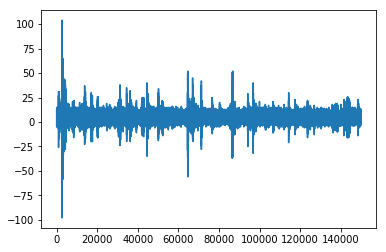

In [4]:
# plot the head of the seismic acoustic data
plt.plot(X_train[0:150000])

In [5]:
X_train = np.reshape(X_train[0:(segments * rows)], (segments, rows,1))
X_train.shape

(4100, 150000, 1)

In [ ]:
# Sanity check - plot the head of the seismic acoustic data
# plt.plot(X_train[0,:])

In [6]:
y_train = np.zeros(segments)
for segment in tqdm(range(segments)):
    seg = y_raw[segment*rows:segment*rows+rows]
    y_train[segment] = seg[-1]
median = np.median(y_train)
overall_max = y_train.max()
print ("time to failure median", median, "and maximum", overall_max)

100%|██████████| 4100/4100 [00:00<00:00, 590300.92it/s]

time to failure median 5.349609375 and maximum 16.109375


In [7]:
# add the "pull alarm" category
y_pull_alarm = np.zeros(segments)
for segment in tqdm(range(segments)):
    y = y_train[segment]
    if (y <= median) :
        y_pull_alarm[segment] = 1
    else :
        y_pull_alarm[segment] = 0
print("Only pull the alarm if the time to failure is less than or equal to", median)

100%|██████████| 4100/4100 [00:00<00:00, 975087.68it/s]

Only pull the alarm if the time to failure is less than or equal to 5.349609375


The original target data in BLUE is plotted alongside the newly added pull_alarm decision data in ORANGE.


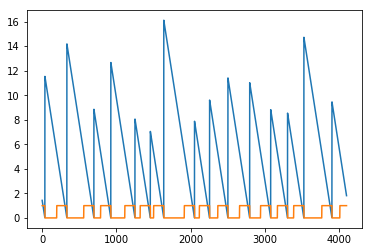

In [8]:
print("The original target data in BLUE is plotted alongside the newly added pull_alarm decision data in ORANGE.")
plt.plot(y_train)
plt.plot(y_pull_alarm)

In [9]:
# Clean up unused RAM 
del y_raw
del chunk

**Making plans for future modifications.**

As per the FDA document relating to Medical Devices, modifications are divided into three broad categories as follows:
* Performance - Example: re-training with new data sets within the intended use population from the same type of input signal. 
* Inputs - Example: modifications to inputs and/or algorithms with no change in intended use.
* Intended Use - Example: Change from a laboratory prediction to a real-world use and/or change from informing to driving or taking action.

It is clear that if this Kernel is to ever be put into use serving the population living in earthquake areas, there will be a change of intended use. In addition, a change to improve performance as well as inputs will likely also occur as part of this.

**Additional Details**

When it comes to all changes, we want to make sure that the device is accurate, reliable, precise, and achieves the intended purpose. Because of this, we need to understand the meaning of these terms and relate them to our application.

Accuracy and Precision: Accuracy refers to the closeness of a measured value to a standard or known value. This competition uses Mean Absolute Error to measure accuracy, and this is a valid measure because it is of the same scale as the Time_to_Failure. Precision, on the other hand, refers to the closeness of two or more measurements to each other. We may want to add training samples that are include additive gaussian white noise (AGWN) to see that small changes to the measurements do not yield large changes to the output (especially with regard ot pulling the alarm).

Sometimes precision is equated to "reliability", although the latter is a measure of how dependably an observation is exactly the same when repeated. It could be over several earthquakes, or over several sensors measuring the same earthquake.

Sometimes accuract is equated to "achieving the intended purpose", although the latter assumes that indeed we have chosen the correct training set that allows us to generalize to the real world population of earthquakes.

**What does that mean to the software?***

I'm still trying figure out what "planning for future modifications" might mean. Below I am trying out one idea.

In all of the above situations, it means that we must use "a priori" methods, such as the "scaler parameters" calculations below, on the original training data, and then AFTERWARDS make additions to our training set (adding noise, additional sensor measurements, etc.) otherwise we will not really be training to improve accuracy and precision.

So for this reason, we create and scale the training data set, and then afterwards add some AGWN for additional sanity check to see if our precision and accuracy are greatly affected.

Other ideas?

In [33]:
# Make a CNN Model to learn features
def make_model(linear = True) :
    
    scale = 1
    droput = 0.1

    # use a simple sequential convolutional neural network model
    model2 = Sequential()
    model2.add(Conv1D(int(12 * scale), 3, strides = 1, activation='relu', input_shape=(rows,1)))
    model2.add(MaxPooling1D(pool_size = 10))
    model2.add(BatchNormalization())
    model2.add(Dropout(droput))

    model2.add(Conv1D(int(100 * scale), 3, strides = 1, activation='relu'))
    model2.add(Dropout(droput))
    model2.add(MaxPooling1D(pool_size = 2))

    model2.add(Conv1D(int(200 * scale), 3, strides = 1, activation='relu'))
    model2.add(Dropout(droput))
    model2.add(MaxPooling1D(pool_size = 2))

    model2.add(Conv1D(int(300 * scale), 3, strides = 1, activation='relu'))
    model2.add(Dropout(droput))
    model2.add(MaxPooling1D(pool_size = 2))

    model2.add(Conv1D(int(200 * scale), 3, strides = 1, activation='relu'))
    model2.add(Dropout(droput))
    model2.add(MaxPooling1D(pool_size = 2))

    model2.add(Conv1D(int(100 * scale), 3, strides = 1, activation='relu'))
    model2.add(Dropout(droput))
    model2.add(MaxPooling1D(pool_size = 2))

    # Include a couple of dense layers in case the classes are not linearly seperable by this point
    model2.add(Flatten())
    model2.add(Dropout(droput))

    model2.add(Dense(int(100 * scale), activation='relu'))
    model2.add(Dropout(droput))

    model2.add(Dense(int(100 * scale), activation='relu'))
    model2.add(Dropout(droput))

    if (linear == True) : 
        model2.add(Dense(1, activation = 'linear'))
    else :
        model2.add(Dense(1, activation = 'sigmoid'))
       
    
    # binary_crossentropy is used as the error function when we have only two choices, like "pull_alarm"
    if (linear == True) : 
        model2.compile(loss='mse', optimizer='adam')
    else :
        # by all rights, should probably use binary_crossentropy below, but seems to get stuck if I do (mse works). Will investigate further at some other time.
        model2.compile(loss='mse', optimizer='adam')
        
    return model2

In [37]:
# we will be slowing down the learning using "Dropouts" (see above) so the patience needed to exit local minima can be large
patience = 15
# Probably will never reach this many epochs, but want to use a number larger than what we expect
epochs = 300
# Divide the data into 15 different versions of training/validation
# n_fold = 15
# Using KFold instead of StratifiedKFold becuase there is a low degree of confidence that the test classification distributions 
# or more importantly, the real world classification probabilities, are equal to those found in the training set
# folds = KFold(n_splits=n_fold, shuffle=False, random_state=1234)

sam = X_train.shape[0]
col = X_train.shape[1]

# sam_test = X_test.shape[0]
# col_test = X_test.shape[1]

# prediction = np.zeros((sam_test, y_count))

model = make_model()

checkpointer = ModelCheckpoint('LANL_value', verbose=1, save_best_only=True)

earlystopper = EarlyStopping(patience = patience, verbose=1) 

results = model.fit(X_train, y_train, epochs = epochs, batch_size = 32,
                    callbacks=[earlystopper, checkpointer], validation_split=0.2)

model = load_model('LANL_value')

Train on 3280 samples, validate on 820 samples
Epoch 1/300
1184/3280 [=========>....................] - ETA: 19s - loss: 27.4795

KeyboardInterrupt: 

In [ ]:
print(model.summary())

In [ ]:
# SCORE FOR SCALED TRAINING SET
y_pred = model.predict(X_train)
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [ ]:
score = mean_absolute_error(y_train, y_pred)
print(f'Score: {score:0.3f}')

**As noted above...***

I'm still trying figure out what "planning for future modifications" might mean. Below I am trying out one idea.

In all of the above situations, it means that we must use "a priori" methods, such as the "scaler parameters" calculations below, on the original training data, and then AFTERWARDS make additions to our training set (adding noise, additional sensor measurements, etc.) otherwise we will not really be training to improve accuracy and precision.

So for this reason, we create and scale the training data set, and then afterwards add some additive gaussian white noise (AGWN) for additional sanity check to see if our precision and accuracy are greatly affected.

Other ideas?

In [ ]:
# Create a version of the scaled training set that has 20% additive gaussian white noise slapped on top.
X_train_random = X_train + (np.random.rand(X_train.shape[0],X_train.shape[1],1) * 0.2)

In [ ]:
# SCORE FOR RANDOMIZED TRAINING SET
y_pred = model.predict(X_train_random)
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [ ]:
score = mean_absolute_error(y_train, y_pred)
print(f'Score: {score:0.3f}')

In [ ]:
del X_train_random

** Now Back to an alternative Purpose **

What if instead of training to find out how much time there is, we instear train to find out if we should pull the alarm or not...

In [38]:
# we will be slowing down the learning using "Dropouts" (see above) so the patience needed to exit local minima can be large
patience = 15
# Probably will never reach this many epochs, but want to use a number larger than what we expect
epochs = 300

model_pull_alarm = make_model(linear = False)

checkpointer = ModelCheckpoint('LANL_value_pull_alarm', verbose=1, save_best_only=True)

earlystopper = EarlyStopping(patience = patience, verbose=1) 

results = model_pull_alarm.fit(X_train, y_pull_alarm, epochs = epochs, batch_size = 32,
                    callbacks=[earlystopper, checkpointer], validation_split=0.2)

model_pull_alarm = load_model('LANL_value_pull_alarm')

Train on 3280 samples, validate on 820 samples
Epoch 1/300
 736/3280 [=====>........................] - ETA: 30s - loss: 0.2405

KeyboardInterrupt: 

In [35]:
print(model_pull_alarm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 149998, 12)        48        
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 14999, 12)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 14999, 12)         48        
_________________________________________________________________
dropout_91 (Dropout)         (None, 14999, 12)         0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 14997, 100)        3700      
_________________________________________________________________
dropout_92 (Dropout)         (None, 14997, 100)        0         
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 7498, 100)         0         
__________

In [ ]:
# SCORE "PULL_ALARM" VALUE FOR SCALED TRAINING SET
y_pred = model_pull_alarm.predict(X_train)
plt.figure(figsize=(6, 6))
plt.scatter(y_pull_alarm, y_pred)
plt.xlim(-.1, 1.1)
plt.ylim(-2, 2)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [ ]:
score = mean_absolute_error(y_pull_alarm, y_pred)
print(f'Score: {score:0.3f}')

In [ ]:
# spread out the results to the desired range of 0 to 1
ymin = y_pred.min()
ymax = y_pred.max()
y_pred = ((y_pred - ymin) / (ymax - ymin))

# Categorize the time remaining as being large (if we are not pulling the alarm) or small (if we are)
y_pred = overall_max * (1 - y_pred)

plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [ ]:
score = mean_absolute_error(y_train, y_pred)
print(f'Score: {score:0.3f}')

In [ ]:
y_pred_pull_alarm = y_pred

y_pred = model.predict(X_train)
# Now combine it with our original time to fault estimates
y_pred = (y_pred_pull_alarm + y_pred) / 2

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [ ]:
score = mean_absolute_error(y_train, y_pred)
print(f'Score: {score:0.3f}')

**Using good machine learning practices learned from medicine.**

In the aforementioned FDA document, a number of steps and documentation and procedural aspects are discussed. These are definitely worth reading in detail - and if you are familiar with Kaggle competitions, you'll find much of this familiar, but below is a biref summary..

**For the initially created SaMD, the steps include:**
* Data selection and management
* Model training and tuning
* Performance and Clinical model validation
* Premarket testing

**For modfications (which should be planned for) the steps include:**
* Data for re-training
* All of the usual steps abve, with the addition of SaMD Pre-specifications and Algorithm Change Protocol

**Documentation should include:**
1. Establish clear expectations on quality systems and good ML practices (GMLP);
2. Conduct premarket review for those SaMD that require premarket submission to demonstrate reasonable assurance of safety and effectiveness and establish clear expectations for manufacturers of AI/ML-based SaMD to continually manage patient risks throughout the lifecycle;
3. Expect manufacturers to monitor the AI/ML device and incorporate a risk management approach and other approaches utlined in “Deciding When to Submit a 510(k) for a Software Change to an Existing Device” Guidance18 in development, validation, and execution of he algorithm changes (SaMD Pre-Specifications and Algorithm Change Protocol); and
4. Enable increased transparency to users and FDA using postmarket real-world performance reporting for maintaining continued assurance of safety and effectiveness.

**What does this mean for the software?**

As a Kaggle competition entrant, mostly just the documentation of the above will be sufficient - while adherence to Good Machine Learning Practices (GMLP) should be something you are doing anyway. In the case of this competition, the rules for submissions have already been set - whereas the rules for submission of medical trial documentation will have its own (lengthly) rules which must be adhered to.

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [ ]:
del X_train
del y_train
del y_pred

In [ ]:
rows = 150_000
segment = 0
for seg_id in tqdm(submission.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    if (segment == 0) :
        X_test = np.int16(seg.acoustic_data.values)
    else: 
        X_test = np.concatenate((X_test, np.int16(seg.acoustic_data.values)))
    segment += 1
segments = segment

In [ ]:
# plot the head of the seismic acoustic data
plt.plot(X_test[0:150000])

In [ ]:
X_test = np.reshape(X_test, (segments, rows,1))
X_test.shape

In [ ]:
# Sanity check - plot the head of the seismic acoustic data
plt.plot(X_test[0,:])

In [ ]:
print("saving PULL_ALARM estimates, scaled to time")
y_pred = model_pull_alarm.predict(X_test)
# spread out the results to the desired range of 0 to 1
ymin = y_pred.min()
ymax = y_pred.max()
y_pred = ((y_pred - ymin) / (ymax - ymin))
# Categorize the time remaining as being large (if we are not pulling the alarm) or small (if we are)
y_pred = overall_max * (1 - y_pred)
submission['time_to_failure'] = y_pred
submission.to_csv('submission_pull_alarm.csv')

print("saving TIME_TO_FAILURE estimates")
y_pred_pull_alarm = y_pred
y_pred = model.predict(X_test)
submission['time_to_failure'] = y_pred
submission.to_csv('submission_time_to_failure.csv')

print("saving average of the above estimates")
# Now combine it with our original time to fault estimates
y_pred = (y_pred_pull_alarm + y_pred) / 2
submission['time_to_failure'] = y_pred
submission.to_csv('submission.csv')

print("done!")